In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [15]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data preprocessing

#### Handle categorical variables & missing values

In [16]:
def process_data(df: pd.DataFrame, modes):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

In [17]:
modes = train_df.mode().iloc[0]
process_data(train_df, modes)
process_data(test_df, modes)

In [19]:
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = 'Survived'

In [20]:
train_df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

#### Visualize male/female split (Survival rate & count)

[Text(0.5, 1.0, 'Histogram')]

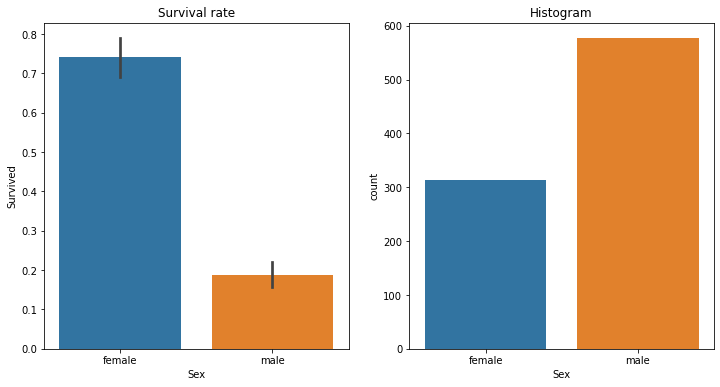

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.barplot(data=train_df, y=dep, x='Sex', ax=ax[0]).set(title='Survival rate')
sns.countplot(data=train_df, x='Sex', ax=ax[1]).set(title='Histogram')

#### Split train/validation data

In [22]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
train_df, val_df = train_test_split(train_df, test_size=0.25)
train_df[cats] = train_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [24]:
def xs_y(df: pd.DataFrame):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

In [28]:
train_xs, train_y = xs_y(train_df)
val_xs, val_y = xs_y(val_df)

##### Dummy model #1 (considering Sex)

In [29]:
preds = val_xs.Sex == 0

In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

##### Dummy model #2 (considering LogFare)

<AxesSubplot:xlabel='LogFare', ylabel='Density'>

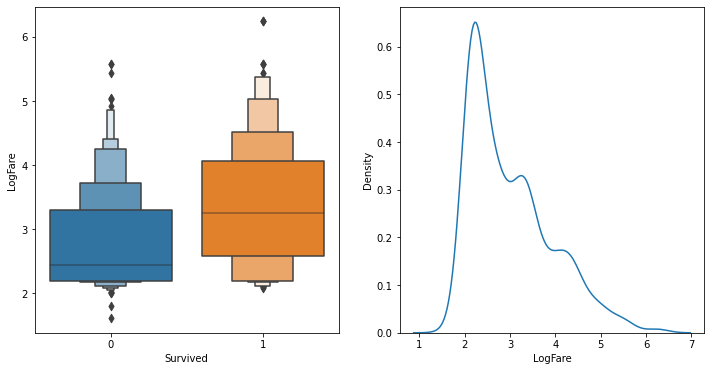

In [32]:
df_fare = train_df[train_df.LogFare > 0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=ax[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=ax[1])

In [33]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y, preds)

0.336322869955157

In [34]:
def _side_score(side, y):
    tot = side.sum()
    if tot <= 1:
        return 0
    return y[side].std() * tot

def score(col, y, split):
    lhs = col <= split
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

In [35]:
score(train_xs['Sex'], train_y, 0.5)

0.4078753098206398

In [36]:
score(train_xs['LogFare'], train_y, 2.7)

0.4718087395209973